In [17]:
import torch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# Overall workflow and training

Data generation/training can be performed by built-in executable `lasdi`. For this example of Burgers 1D equation, you can simply run on command-line terminal:
```
lasdi burgers1d.yml
```

The workflow can be also manually constructed for those who prefer python scripts and for prototyping. The following code snippets show the high-level view of the workflow in the executable `lasdi`.

In [2]:
import yaml
# add parent directory to path
# from os import sys, path
# sys.path.append('../')
# from src.lasdi.workflow import initialize_trainer, run_samples, pick_samples

from lasdi.workflow import initialize_trainer, run_samples, pick_samples

cfg_file = 'burgers1d-nonadaptive.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

trainer, param_space, physics, autoencoder, sindy = initialize_trainer(config)
print("Trainer initialized with the following configuration:")
print(param_space.train_space)

# generate initial training/test data
pick_samples(trainer, config)
print("Initial samples picked for training")
print(trainer.X_train.shape)
# run_samples(trainer, config, save_samples=True)
run_samples(trainer, config)
print(trainer.X_train.shape)
print("Training data generated")
# initial training given training data

trainer.train()

while (trainer.restart_iter < trainer.max_iter):
    if (trainer.restart_iter <= trainer.max_greedy_iter):
        # perform greedy sampling to pick up new samples
        pick_samples(trainer, config)
        # update training data with newly picked samples
        run_samples(trainer, config)

    # train over given training data
    trainer.train()

/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/lasdi/inputs.py:37: UserWarning: <class 'str'> does not match the type with the fallback value <class 'int'>!
  warn("%s does not match the type with the fallback value %s!" % (str(type(val)), str(type(fallback))))


Trainer initialized with the following configuration:
[[0.7  0.9 ]
 [0.75 0.9 ]
 [0.8  0.9 ]
 [0.85 0.9 ]
 [0.9  0.9 ]
 [0.7  0.97]
 [0.75 0.97]
 [0.8  0.97]
 [0.85 0.97]
 [0.9  0.97]
 [0.7  1.04]
 [0.75 1.04]
 [0.8  1.04]
 [0.85 1.04]
 [0.9  1.04]
 [0.7  1.1 ]
 [0.75 1.1 ]
 [0.8  1.1 ]
 [0.85 1.1 ]
 [0.9  1.1 ]]
Initial samples picked for training
torch.Size([0])
Loading samples from hdf5 file...
torch.Size([20, 1001, 1001])
Training data generated
Iter: 00001/20000, Loss: 0.2360397130, Loss AE: 0.2360319942, Loss LD: 0.0000031773, Loss COEF: 153.9928894043, max|c|: 04.9, Param: ..., [0.9  1.04], [0.7 1.1], [0.75 1.1 ], [0.8 1.1], [0.85 1.1 ], [0.9 1.1]
Iter: 00002/20000, Loss: 0.1980345100, Loss AE: 0.1980265379, Loss LD: 0.0000021353, Loss COEF: 159.2110595703, max|c|: 05.2, Param: ..., [0.9  1.04], [0.7 1.1], [0.75 1.1 ], [0.8 1.1], [0.85 1.1 ], [0.9 1.1]
Iter: 00003/20000, Loss: 0.1659108847, Loss AE: 0.1659035236, Loss LD: 0.0000030903, Loss COEF: 146.9652099609, max|c|: 05.6, Pa

KeyboardInterrupt: 

If you ran the command instead, a restart file is saved at the end of the training, which can be loaded for post-processing:

In [77]:
# Specify the restart file you have.
# filename = 'lasdi_06_17_2025_17_43.npy'
# filename = 'lasdi_07_08_2025_21_56.npy'
# filename = 'lasdi_08_13_2025_15_43.npy'
filename = 'pareto-experiments/burgers1d-NA-MI5000-HU25.npy'
import yaml
from lasdi.workflow import initialize_trainer
from lasdi.param import ParameterSpace

cfg_file = 'pareto-experiments/burgers1d-NA-debug.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

restart_file = np.load(filename, allow_pickle=True).item()
print(restart_file.keys())

trainer, param_space, physics, autoencoder, sindy = initialize_trainer(config, restart_file)

print(restart_file.keys())
print(restart_file['num_params'])

dict_keys(['parameters', 'physics', 'latent_space', 'latent_dynamics', 'trainer', 'timestamp', 'result', 'max_rel_err', 'avg_rel_err', 'num_params', 'train_time', 'eval_time'])
dict_keys(['parameters', 'physics', 'latent_space', 'latent_dynamics', 'trainer', 'timestamp', 'result', 'max_rel_err', 'avg_rel_err', 'num_params', 'train_time', 'eval_time'])


/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/lasdi/inputs.py:37: UserWarning: <class 'str'> does not match the type with the fallback value <class 'int'>!
  warn("%s does not match the type with the fallback value %s!" % (str(type(val)), str(type(fallback))))


In [19]:

print(trainer.param_space.train_space)
print(trainer.X_train)

def count_params(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

print("Number of parameters in the model:", count_params(autoencoder))

[[0.7  0.9 ]
 [0.75 0.9 ]
 [0.8  0.9 ]
 [0.85 0.9 ]
 [0.9  0.9 ]
 [0.7  0.97]
 [0.75 0.97]
 [0.8  0.97]
 [0.85 0.97]
 [0.9  0.97]
 [0.7  1.04]
 [0.75 1.04]
 [0.8  1.04]
 [0.85 1.04]
 [0.9  1.04]
 [0.7  1.1 ]
 [0.75 1.1 ]
 [0.8  1.1 ]
 [0.85 1.1 ]
 [0.9  1.1 ]]
tensor([[[0.0027, 0.0028, 0.0028,  ..., 0.0028, 0.0028, 0.0027],
         [0.0027, 0.0028, 0.0028,  ..., 0.0028, 0.0028, 0.0027],
         [0.0027, 0.0028, 0.0028,  ..., 0.0028, 0.0028, 0.0027],
         ...,
         [0.0027, 0.0028, 0.0028,  ..., 0.0029, 0.0028, 0.0027],
         [0.0027, 0.0028, 0.0028,  ..., 0.0029, 0.0028, 0.0027],
         [0.0027, 0.0028, 0.0028,  ..., 0.0029, 0.0028, 0.0027]],

        [[0.0029, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0029],
         [0.0029, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0029],
         [0.0029, 0.0030, 0.0030,  ..., 0.0030, 0.0030, 0.0029],
         ...,
         [0.0029, 0.0029, 0.0030,  ..., 0.0031, 0.0030, 0.0029],
         [0.0029, 0.0029, 0.0030,  ..., 0.0031, 0.0030, 0.0

# Post-processing

Load data for post-processing:

In [6]:
coefs = trainer.best_coefs
X_train = trainer.X_train
X_test = trainer.X_test

param_train = param_space.train_space
param_grid = param_space.test_space
test_meshgrid = param_space.test_meshgrid
test_grid_sizes = param_space.test_grid_sizes
n_init = param_space.n_init

n_a_grid, n_w_grid = test_grid_sizes
a_grid, w_grid = test_meshgrid

t_grid = physics.t_grid
x_grid = physics.x_grid
t_mesh, x_mesh = np.meshgrid(t_grid, x_grid)
Dt, Dx = physics.dt, physics.dx

time_dim, space_dim = t_grid.shape[0], x_grid.shape[0]

n_coef = sindy.ncoefs

They can be also loaded directly from restart file:

In [20]:
coefs = restart_file['trainer']['best_coefs']
X_train = restart_file['trainer']['X_train']
X_test = restart_file['trainer']['X_test']

paramspace_dict = restart_file['parameters']
param_train = paramspace_dict['train_space']
param_grid = paramspace_dict['test_space']
test_meshgrid = paramspace_dict['test_meshgrid']
test_grid_sizes = paramspace_dict['test_grid_sizes']
n_init = paramspace_dict['n_init']

n_a_grid, n_w_grid = test_grid_sizes
a_grid, w_grid = test_meshgrid

physics_dict = restart_file['physics']
t_grid = physics_dict['t_grid']
x_grid = physics_dict['x_grid']
t_mesh, x_mesh = np.meshgrid(t_grid, x_grid)
Dt = physics_dict['dt']
Dx = physics_dict['dx']

time_dim, space_dim = t_grid.shape[0], x_grid.shape[0]
n_coef = restart_file['latent_dynamics']['ncoefs']

## Gaussian-process uncertainty evaluation
We evaluated the uncertainties of latent dynamics coefficients over 2d parameter space, with samples from GP prediction:

In [21]:
from lasdi.gp import fit_gps
from lasdi.gplasdi import sample_roms, average_rom
from lasdi.postprocess import compute_errors
from lasdi.gp import eval_gp

n_samples = 20
autoencoder.cpu()

gp_dictionnary = fit_gps(param_space.train_space, coefs)

Zis_samples = sample_roms(autoencoder, physics, sindy, gp_dictionnary, param_grid, n_samples)
Zis_mean = average_rom(autoencoder, physics, sindy, gp_dictionnary, param_grid)

X_pred_mean = autoencoder.decoder(torch.Tensor(Zis_mean)).detach().numpy()
X_pred_samples = autoencoder.decoder(torch.Tensor(Zis_samples)).detach().numpy()

avg_rel_error = np.zeros(param_grid.shape[0])
print(X_pred_mean.shape)
breakpoint
for k in range(param_grid.shape[0]):
    avg_rel_error[k], _ = compute_errors(X_pred_mean[k], physics, X_test[k].numpy())

max_std = np.zeros(param_grid.shape[0])
for k in range(param_grid.shape[0]):
    max_std[k] = X_pred_samples[k].std(0).max()

avg_rel_error = avg_rel_error.reshape([n_w_grid, n_a_grid]).T
max_std = max_std.reshape([n_w_grid, n_a_grid]).T

gp_pred_mean, gp_pred_std = eval_gp(gp_dictionnary, param_grid)

/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/margaret/

(441, 1001, 1001)


# Visualization

Plot mean and standard deviation of coefficient matrix.
For SINDy of dimension 5, the coefficient matrix has a shape of (6, 5).

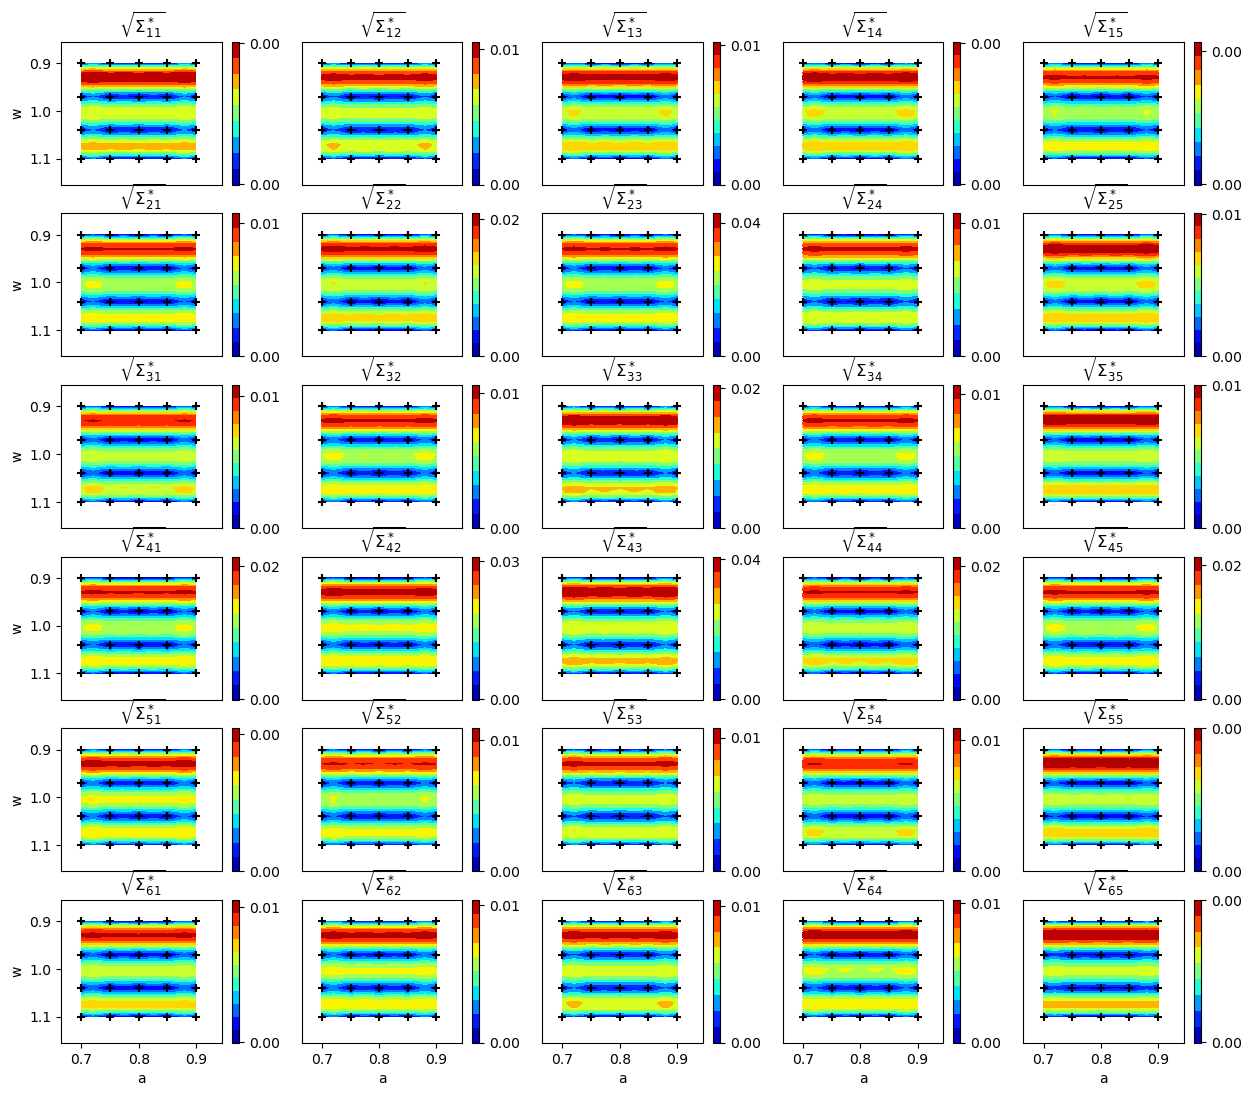

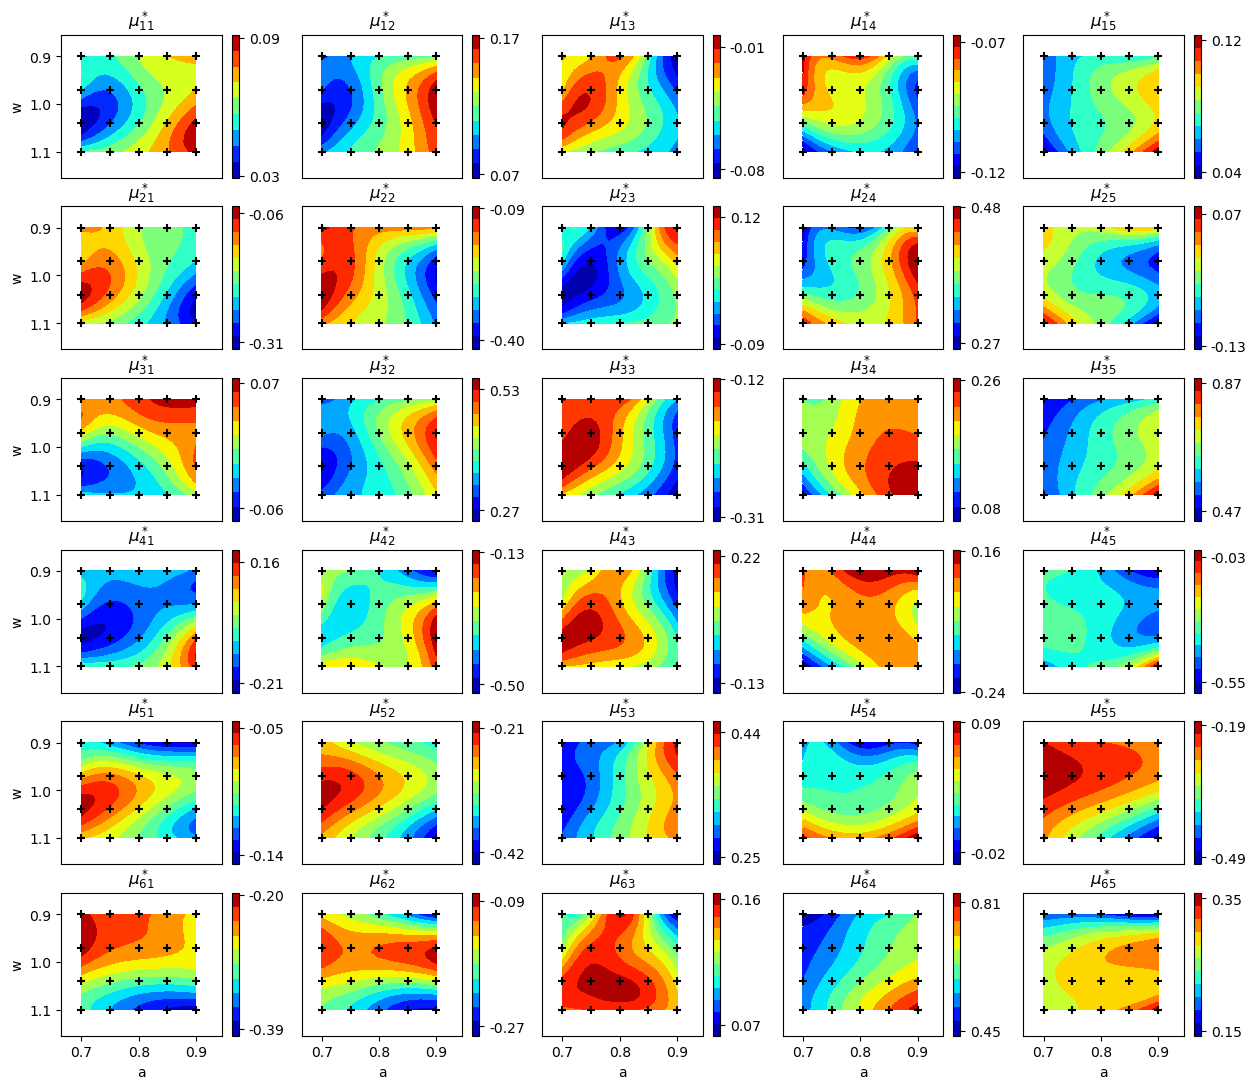

In [22]:
from lasdi.postprocess import plot_gp2d

plot_gp2d(a_grid, w_grid, gp_pred_mean.reshape([n_a_grid, n_w_grid, -1]), gp_pred_std.reshape([n_a_grid, n_w_grid, -1]),
          param_train, param_labels=['a', 'w'], plot_shape=[6, 5])

(21, 21)
(21, 21)
(20, 2)


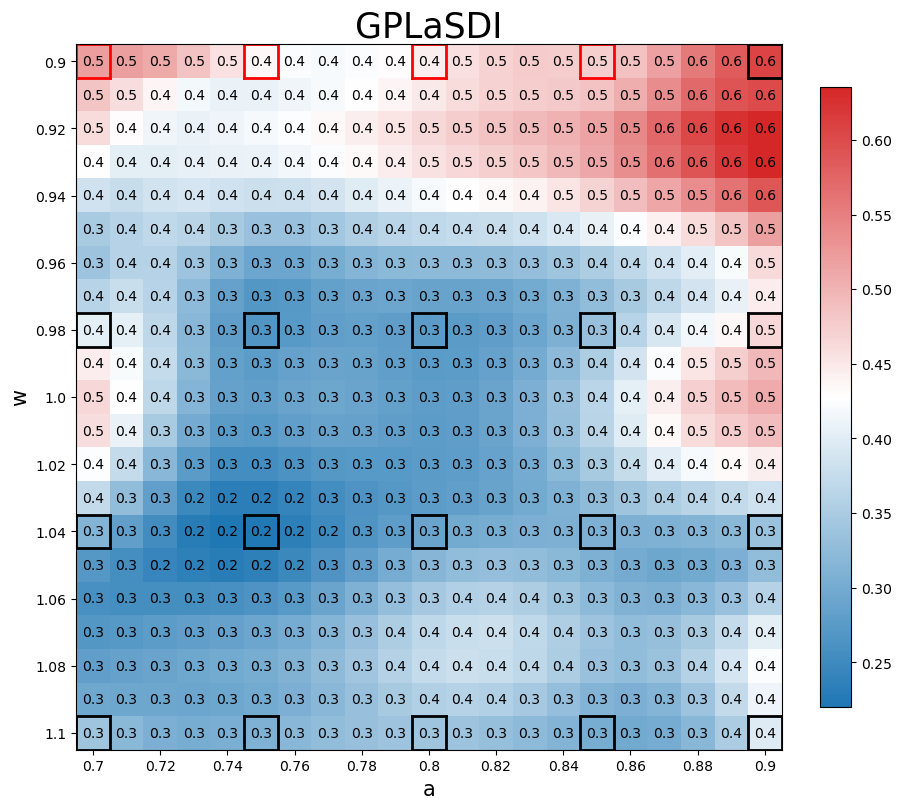

In [23]:
from lasdi.postprocess import heatmap2d
print(a_grid.shape)
print(avg_rel_error.shape)
print(param_train.shape)
heatmap2d(avg_rel_error * 100, a_grid[:, 0], w_grid[0], param_train, 4, param_labels=['a', 'w'], title='GPLaSDI')

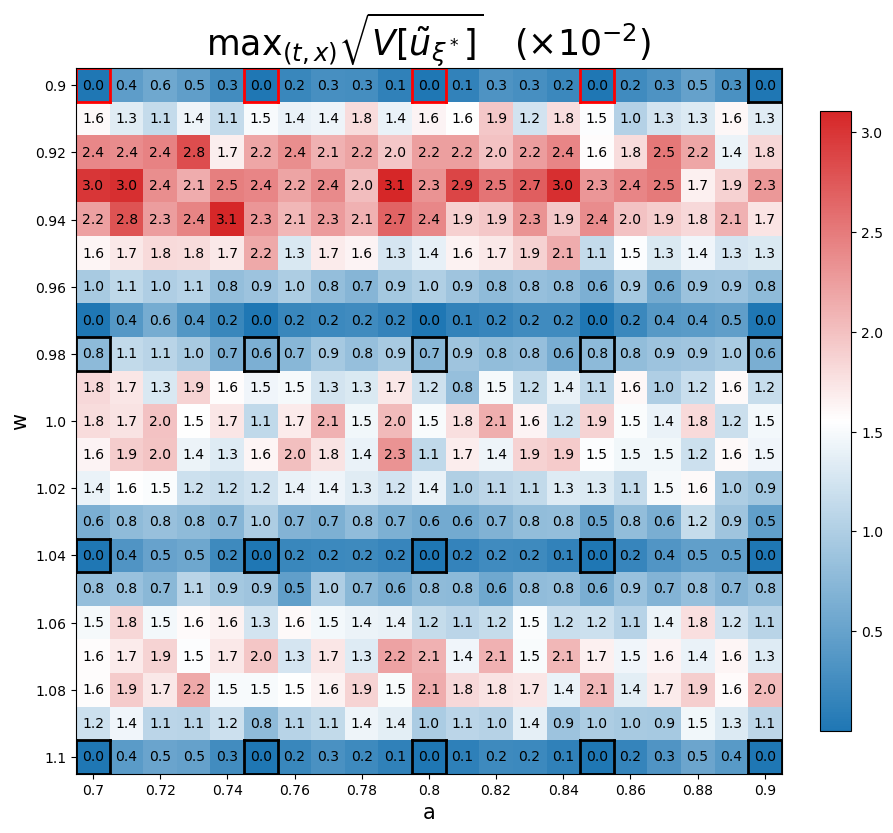

In [24]:
heatmap2d(max_std * 100, a_grid[:, 0], w_grid[0], param_train, 4, param_labels=['a', 'w'], title=r'max$_{(t,x)}\sqrt{V[\tilde{u}_{\xi^*}]}$   ($\times10^{-2}$)')

/Users/margaret/anaconda3/envs/python3.9/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


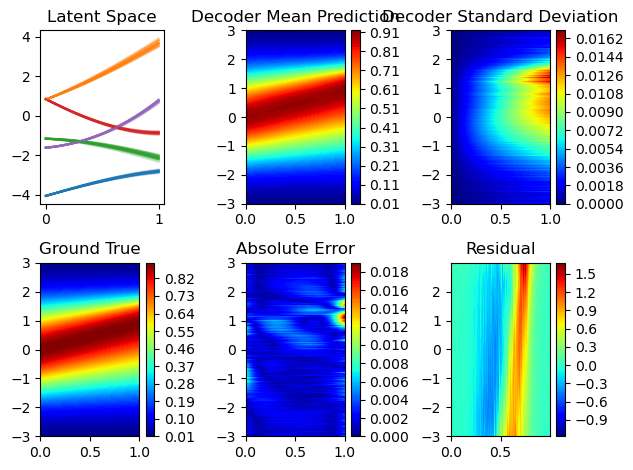

In [25]:
from lasdi.postprocess import plot_prediction

a, w = 0.9, 1.07
param = np.array([[a, w]])
true = physics.solve(param[0])
true = true.detach().numpy().reshape([physics.grid_size[0], physics.nt]).T
scale = 1

Z = sample_roms(autoencoder, physics, sindy, gp_dictionnary, param, n_samples)

Z_mean = Z[0].mean(0)
Z_std = Z[0].std(0)

pred = autoencoder.decoder(torch.Tensor(Z)).detach().numpy()
pred_std = pred[0].std(0)

plot_prediction(param, autoencoder, physics, sindy, gp_dictionnary, n_samples, true, scale)

## Greedy interpolation

In [63]:
def get_greedy_coef(param_train, train_coefs, param_test):
    '''
    Finds nearest point in param_train to param_test and takes the corresponding coefficient.

    '''
    dists = np.linalg.norm(param_train - param_test, axis=1)
    idx = np.argmin(dists)

    return train_coefs[idx]

In [62]:
from lasdi.latent_space import initial_condition_latent
param_train = param_space.train_space
train_coefs = coefs 
test_coefs = [get_greedy_coef(param_train, train_coefs, param) for param in param_grid]
Z0 = initial_condition_latent(param_grid, physics, autoencoder)
predictions = np.zeros((param_grid.shape[0], physics.grid_size[0], physics.nt))
n_test = param_grid.shape[0]
for i in range(n_test):
    prediction = sindy.simulate(test_coefs[i], Z0[i], physics.t_grid) 
    predictions[i] = autoencoder.decoder(torch.Tensor(prediction)).detach().numpy()
    

avg_rel_error = np.zeros(param_grid.shape[0])


print(X_test[k].shape)

for k in range(param_grid.shape[0]):
    avg_rel_error[k], _ = compute_errors(predictions[k], physics, X_test[k].numpy())
# param_grid is test params

Param:  [0.7 0.9]
Coeff:  [ 0.04657255  0.08612823 -0.02897809 -0.06808643  0.05890118 -0.11201822
 -0.11086585 -0.02342213  0.26999769  0.00730652  0.02871513  0.30784908
 -0.13560836  0.1577182   0.47151077 -0.10474827 -0.30292568  0.08864556
  0.08460511 -0.3276723  -0.10720449 -0.27022076  0.25139257  0.00454004
 -0.21016653 -0.21504231 -0.14938092  0.10610317  0.45396227  0.18002596]
Param:  [0.7  0.97]
Coeff:  [ 0.04862491  0.09032063 -0.03354029 -0.07276697  0.06080015 -0.13450693
 -0.14638665 -0.01627024  0.29021856 -0.00970077  0.02405387  0.33058396
 -0.15178962  0.17434315  0.51498079 -0.09569467 -0.29797974  0.08989373
  0.06178156 -0.33287892 -0.0766151  -0.22713745  0.26980105  0.01455899
 -0.18970673 -0.2080712  -0.09945246  0.11590691  0.49950969  0.25720331]
Param:  [0.7  1.04]
Coeff:  [ 0.02502534  0.07233107 -0.01491588 -0.0966874   0.05986344 -0.06318562
 -0.09498207 -0.09121359  0.36416504 -0.00602881 -0.05829597  0.2724489
 -0.12267812  0.13307329  0.52867764 -0.2

In [49]:
avg_rel_error = avg_rel_error.reshape([n_w_grid, n_a_grid]).T


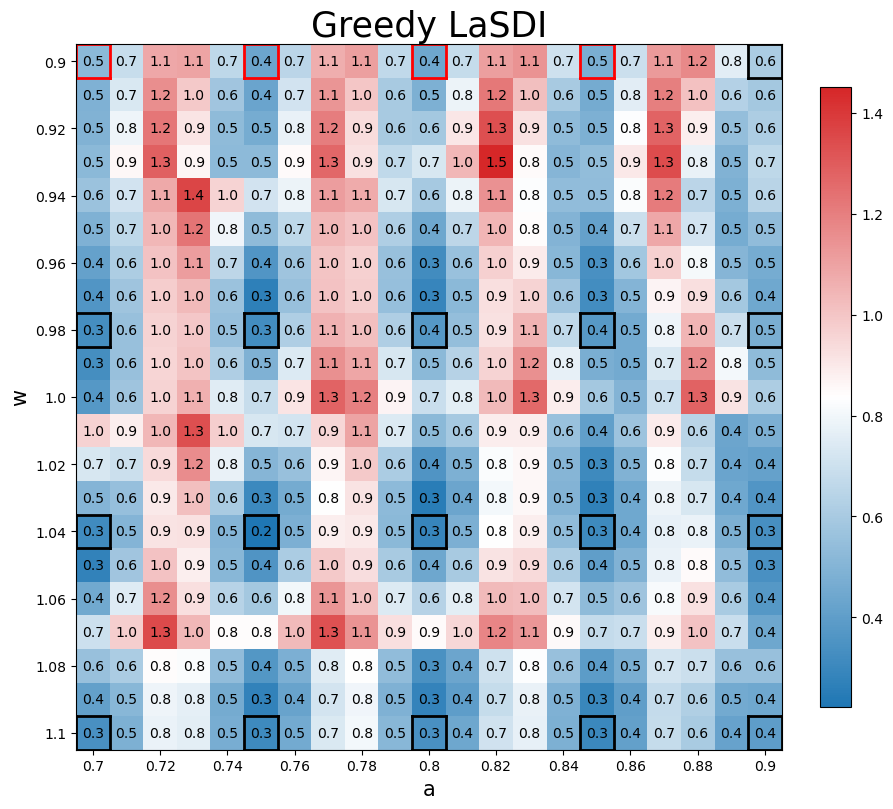

In [50]:
heatmap2d(avg_rel_error * 100, a_grid[:, 0], w_grid[0], param_train, 4, param_labels=['a', 'w'], title='Greedy LaSDI')

## Linear Interpolation 

In [68]:
def get_linear_prediction(param_train, train_coefs, param_test):
    '''
    Linearly interpolates between four nearest points in param_train to param_test

    '''
    dists = np.linalg.norm(param_train - param_test, axis=1)
    if min(dists) < 1e-2:
        idx = np.argmin(dists)
        # find train_coef index corresponding
        return train_coefs[idx]
    else:
        idxs = np.argsort(dists)[:4]
        weights = 1 / dists[idxs]
        weights /= weights.sum()
        return np.dot(weights, train_coefs[idxs])

 

In [69]:
param_train = param_space.train_space
train_coefs = coefs 
test_coefs = [get_linear_prediction(param_train, train_coefs, param) for param in param_grid]
Z0 = initial_condition_latent(param_grid, physics, autoencoder)
predictions = np.zeros((param_grid.shape[0], physics.grid_size[0], physics.nt))
n_test = param_grid.shape[0]
for i in range(n_test):
    prediction = sindy.simulate(test_coefs[i], Z0[i], physics.t_grid) 
    predictions[i] = autoencoder.decoder(torch.Tensor(prediction)).detach().numpy()
    

avg_rel_error = np.zeros(param_grid.shape[0])


print(X_test[k].shape)

for k in range(param_grid.shape[0]):
    avg_rel_error[k], _ = compute_errors(predictions[k], physics, X_test[k].numpy())

torch.Size([1001, 1001])


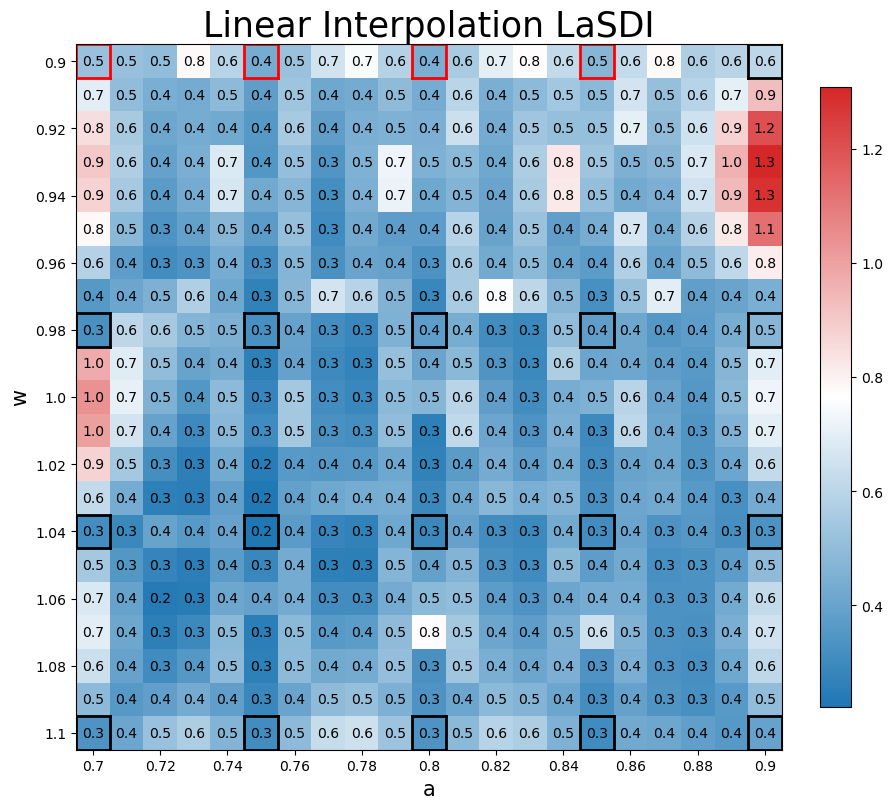

In [70]:
avg_rel_error = avg_rel_error.reshape([n_w_grid, n_a_grid]).T
heatmap2d(avg_rel_error * 100, a_grid[:, 0], w_grid[0], param_train, 4, param_labels=['a', 'w'], title='Linear Interpolation LaSDI')